TRAIN DATA OVERVIEW
Total samples: 31962

Columns: ['id', 'label', 'tweet']

First few rows:
   id  label                                              tweet
0   1      0   @user when a father is dysfunctional and is s...
1   2      0  @user @user thanks for #lyft credit i can't us...
2   3      0                                bihday your majesty
3   4      0  #model   i love u take with u all the time in ...
4   5      0             factsguide: society now    #motivation

CLASS DISTRIBUTION
label
0    29720
1     2242
Name: count, dtype: int64

Percentage distribution:
label
0    92.98542
1     7.01458
Name: proportion, dtype: float64

TWEET LENGTH ANALYSIS
Average tweet length: 84.74 characters
Min length: 11
Max length: 274
Median length: 88.0

SPECIAL CHARACTERS CHECK
Tweets with @mentions: 11683
Tweets with #hashtags: 23522
Tweets with URLs: 0


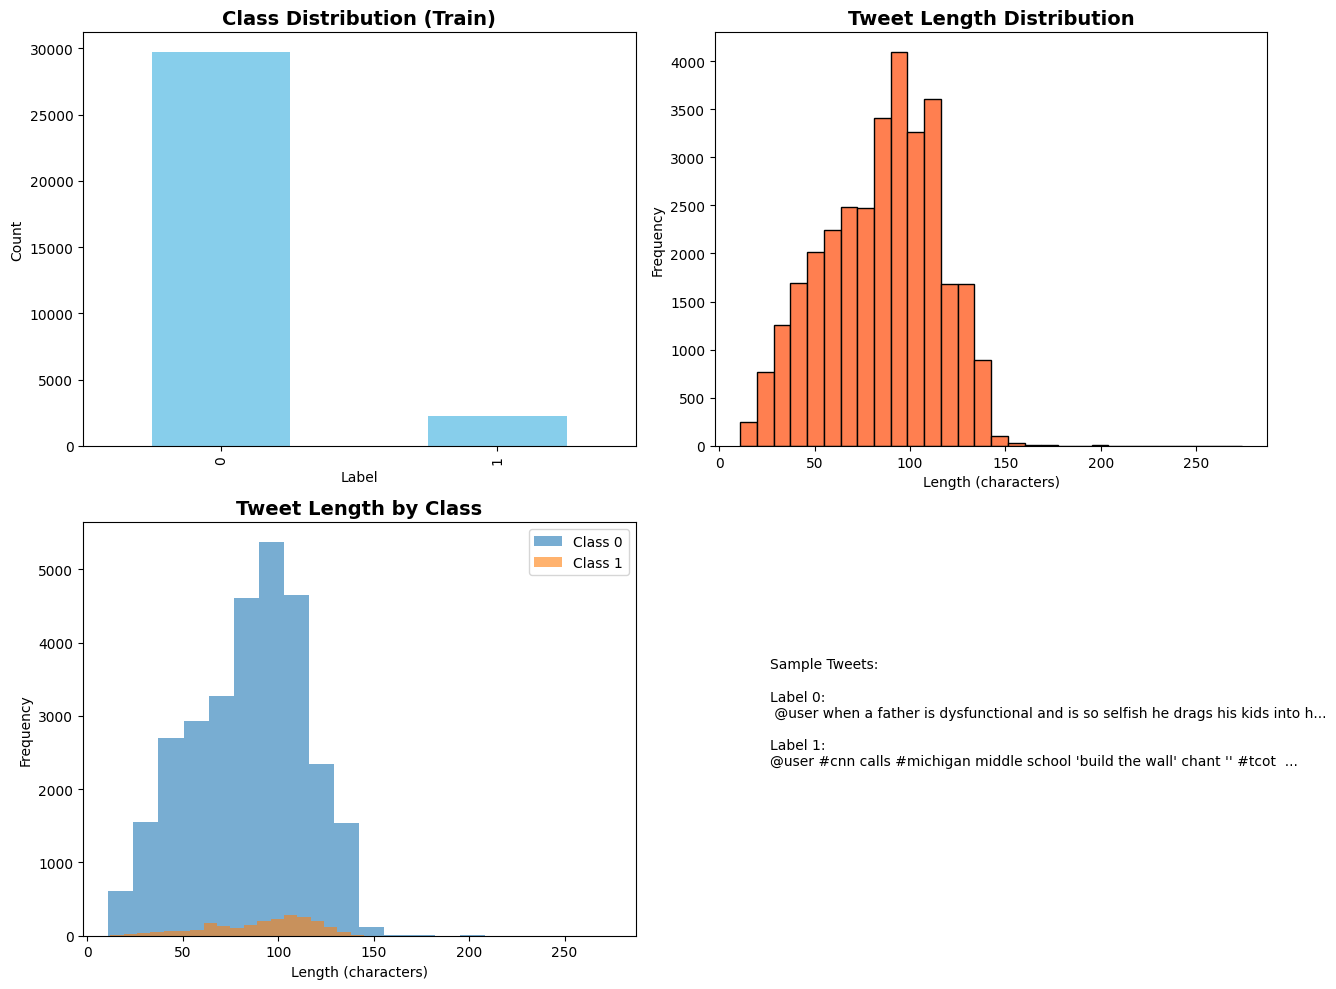


✅ Visualization saved as 'data_exploration.png'


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your data
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")

print("="*50)
print("TRAIN DATA OVERVIEW")
print("="*50)
print(f"Total samples: {len(train_df)}")
print(f"\nColumns: {train_df.columns.tolist()}")
print(f"\nFirst few rows:")
print(train_df.head())

print("\n" + "="*50)
print("CLASS DISTRIBUTION")
print("="*50)
print(train_df['label'].value_counts())
print("\nPercentage distribution:")
print(train_df['label'].value_counts(normalize=True) * 100)

print("\n" + "="*50)
print("TWEET LENGTH ANALYSIS")
print("="*50)
train_df['tweet_length'] = train_df['tweet'].str.len()
print(f"Average tweet length: {train_df['tweet_length'].mean():.2f} characters")
print(f"Min length: {train_df['tweet_length'].min()}")
print(f"Max length: {train_df['tweet_length'].max()}")
print(f"Median length: {train_df['tweet_length'].median()}")

print("\n" + "="*50)
print("SPECIAL CHARACTERS CHECK")
print("="*50)
print(f"Tweets with @mentions: {train_df['tweet'].str.contains('@').sum()}")
print(f"Tweets with #hashtags: {train_df['tweet'].str.contains('#').sum()}")
print(f"Tweets with URLs: {train_df['tweet'].str.contains('http').sum()}")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Class distribution
train_df['label'].value_counts().plot(kind='bar', ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('Class Distribution (Train)', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Label')
axes[0, 0].set_ylabel('Count')

# 2. Tweet length distribution
axes[0, 1].hist(train_df['tweet_length'], bins=30, color='coral', edgecolor='black')
axes[0, 1].set_title('Tweet Length Distribution', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Length (characters)')
axes[0, 1].set_ylabel('Frequency')

# 3. Tweet length by class
for label in train_df['label'].unique():
    subset = train_df[train_df['label'] == label]
    axes[1, 0].hist(subset['tweet_length'], bins=20, alpha=0.6, label=f'Class {label}')
axes[1, 0].set_title('Tweet Length by Class', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Length (characters)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()

# 4. Sample tweets from each class
axes[1, 1].axis('off')
sample_text = "Sample Tweets:\n\n"
for label in train_df['label'].unique():
    sample = train_df[train_df['label'] == label].iloc[0]['tweet']
    sample_text += f"Label {label}:\n{sample[:80]}...\n\n"
axes[1, 1].text(0.1, 0.5, sample_text, fontsize=10, verticalalignment='center')

plt.tight_layout()
plt.savefig('data_exploration.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Visualization saved as 'data_exploration.png'")

In [2]:
import random
import numpy as np
import torch

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed()

In [3]:
import pandas as pd
from torch.utils.data import DataLoader
from src.dataset import HateSpeechDataset, CollateFn

# 1. Load Data
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")

# 2. Setup Training Dataset & Vocab
# We build the vocabulary ONLY on the training data
train_dataset = HateSpeechDataset(train_df, is_test=False)
vocab = train_dataset.vocab  # Save this vocab to use for test!

# 3. Setup Test Dataset
# CRITICAL: Pass the 'vocab' from train to test. 
# Do not build a new vocab for test data!
test_dataset = HateSpeechDataset(test_df, vocab=vocab, is_test=True)

# 4. DataLoaders
pad_idx = vocab.stoi["<PAD>"]

train_loader = DataLoader(
    train_dataset, 
    batch_size=32, 
    shuffle=True, 
    collate_fn=CollateFn(pad_idx=pad_idx, is_test=False)
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=32, 
    shuffle=False, # Don't shuffle test data
    collate_fn=CollateFn(pad_idx=pad_idx, is_test=True)
)

# 5. Quick Check
print("Checking Train Batch:")
for text, label in train_loader:
    print(text.shape, label.shape)
    break

print("\nChecking Test Batch:")
for text in test_loader:
    print(text.shape)
    break

Checking Train Batch:
torch.Size([32, 25]) torch.Size([32])

Checking Test Batch:
torch.Size([32, 21])


In [4]:
import torch.nn as nn
from src.model import LSTMBaseline

# 1. Hyperparameters
INPUT_DIM = len(vocab) # Got from your previous step
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1 # Binary classification (0 or 1)
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = vocab.stoi["<PAD>"]

# 2. Initialize Model
model = LSTMBaseline(
    INPUT_DIM, 
    EMBEDDING_DIM, 
    HIDDEN_DIM, 
    OUTPUT_DIM, 
    N_LAYERS, 
    BIDIRECTIONAL, 
    DROPOUT, 
    PAD_IDX
)

# 3. Test a Forward Pass
# Get a batch from your train_loader
for text_batch, label_batch in train_loader:
    preds = model(text_batch)
    print("Input Shape: ", text_batch.shape) # [32, Seq_Len]
    print("Output Shape:", preds.shape)      # Should be [32, 1]
    break

Input Shape:  torch.Size([32, 22])
Output Shape: torch.Size([32, 1])


In [6]:
import torch.optim as optim
# from sklearn.metrics import f1_score

# --- 1. SETUP DEVICE ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --- 2. CALCULATE CLASS WEIGHTS ---
# We do this BEFORE defining the loss function
num_pos = train_df['label'].sum()              # Count of '1's (Hate)
num_neg = len(train_df) - num_pos              # Count of '0's (Normal)

# Logic: If we have 10x more Normal tweets, we weight Hate tweets 10x more.
# Add a small epsilon (1e-6) to num_pos to avoid division by zero if it's empty
pos_weight_value = num_neg / (num_pos + 1e-6)

print(f"Calculated Positive Weight: {pos_weight_value:.2f}")

# Convert to tensor and move to the correct device (GPU or CPU)
pos_weight = torch.tensor([pos_weight_value]).to(device)

# --- 3. SETUP OPTIMIZER & LOSS ---
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Pass the calculated weight here!
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# Move model and criterion to device
model = model.to(device)
criterion = criterion.to(device)

Calculated Positive Weight: 13.26


In [7]:
import time
import torch.optim as nn
from src.engine import train_one_epoch, evaluate

N_EPOCHS = 5

print(f"Training on device: {device}")

for epoch in range(N_EPOCHS):
    start_time = time.time()
    
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    
    # Note: We don't have a separate validation set in this simple split, 
    # but normally you would pass valid_loader here.
    
    end_time = time.time()
    mins, secs = divmod(end_time - start_time, 60)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {mins}m {secs:.2f}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')

Training on device: cpu
Epoch: 01 | Epoch Time: 1.0m 50.88s
	Train Loss: 1.133 | Train Acc: 81.18%
Epoch: 02 | Epoch Time: 2.0m 0.14s
	Train Loss: 0.893 | Train Acc: 87.35%
Epoch: 03 | Epoch Time: 2.0m 7.36s
	Train Loss: 0.772 | Train Acc: 90.71%
Epoch: 04 | Epoch Time: 2.0m 40.79s
	Train Loss: 0.655 | Train Acc: 92.67%
Epoch: 05 | Epoch Time: 2.0m 11.31s
	Train Loss: 0.587 | Train Acc: 93.77%


In [23]:
def get_test_predictions(model, iterator):
    model.eval()
    all_preds = []
    
    with torch.no_grad():
        for text in iterator:
            text = text.to(device)
            predictions = model(text).squeeze(1)
            # Convert logits -> probabilities -> 0 or 1
            rounded_preds = torch.round(torch.sigmoid(predictions))
            all_preds.extend(rounded_preds.cpu().numpy().astype(int))
            
    return all_preds

# Generate predictions
test_predictions = get_test_predictions(model, test_loader)

# Save to CSV
output_df = test_df.copy()
output_df['prediction'] = test_predictions
output_df[['id', 'prediction']].to_csv('submission.csv', index=False)

print("Submission file saved as 'submission.csv'!")

Submission file saved as 'submission.csv'!
